In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

In [5]:
# step 1 loading dataset
df=pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [6]:
# step 2 – Preprocessing & Preparing the Data
#Step 2.1: Encode Labels
from sklearn.preprocessing import LabelEncoder

# Encode the 'dx' column (diagnosis)
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])
print("Encoded Labels:", dict(zip(le.classes_, le.transform(le.classes_))))


Encoded Labels: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [7]:
# Step 2.2: Add image paths efficiently using vectorized logic
part1_base = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
part2_base = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Construct potential paths
df["part1_path"] = part1_base + df["image_id"] + ".jpg"
df["part2_path"] = part2_base + df["image_id"] + ".jpg"

# Check which path exists
df["image_path"] = df["part1_path"]
df["image_path"] = df["image_path"].where(df["part1_path"].apply(os.path.exists), df["part2_path"])

# Drop temp columns
df.drop(columns=["part1_path", "part2_path"], inplace=True)

# Drop rows where no image found
df.dropna(subset=["image_path"], inplace=True)

df.head()


lesion_id      image_id   dx dx_type   age   sex localization  label  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp      2   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp      2   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp      2   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp      2   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear      2   

                                          image_path  
0  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
1  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
2  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
3  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
4  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...

In [8]:
# Step 2.3: Split Dataset
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))


Training samples: 8012
Validation samples: 2003


In [11]:
# 2.4 (A)
# Convert labels to strings for ImageDataGenerator
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 2.4: Define image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.1,    # Randomly shift images horizontally
    height_shift_range=0.1,   # Randomly shift images vertically
    zoom_range=0.2,           # Randomly zoom
    horizontal_flip=True,     # Randomly flip images
    validation_split=0.2      # Split training data into train/val
)


In [15]:
# Step 2.4 (B): Use ImageDataGenerator (with Augmentation)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)



Found 6410 validated image filenames belonging to 7 classes.
Found 1602 validated image filenames belonging to 7 classes.


In [16]:
# Step 3: Build and compile a basic CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Basic CNN architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # HAM10000 has 7 classes
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753017510.753030      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6, monitor='val_loss')


In [19]:
# Step 4: Train the model
# Train on full dataset (not just 6 steps)
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=25,  # You can increase this to 20-25 later
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1753017527.021540     115 service.cc:148] XLA service 0x7dda340064a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753017527.022517     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753017527.325082     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/200 ━━━━━━━━━━━━━━━━━━━━ 24:22 7s/step - accuracy: 0.0312 - loss: 1.9893

I0000 00:00:1753017531.343636     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 174s 836ms/step - accuracy: 0.6425 - loss: 1.1922 - val_accuracy: 0.6800 - val_loss: 0.9419
Epoch 2/25
  1/200 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7812 - loss: 0.7492

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.7812 - loss: 0.7492 - val_accuracy: 0.6800 - val_loss: 0.9432
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 117s 586ms/step - accuracy: 0.6647 - loss: 0.9969 - val_accuracy: 0.6800 - val_loss: 0.8994
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.5625 - loss: 1.0231 - val_accuracy: 0.6806 - val_loss: 0.9062
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 119s 594ms/step - accuracy: 0.6657 - loss: 0.9643 - val_accuracy: 0.6812 - val_loss: 0.8662
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.7188 - loss: 0.7334 - val_accuracy: 0.6800 - val_loss: 0.8645
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 119s 594ms/step - accuracy: 0.6741 - loss: 0.9019 - val_accuracy: 0.6831 - val_loss: 0.8221
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy: 0.6562 - loss: 0.9979 - val_accuracy: 0.6825 - val_loss: 0.8217
Epoch 9/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 119s 597ms/step - accuracy: 0.6779 - loss: 0.8689 -

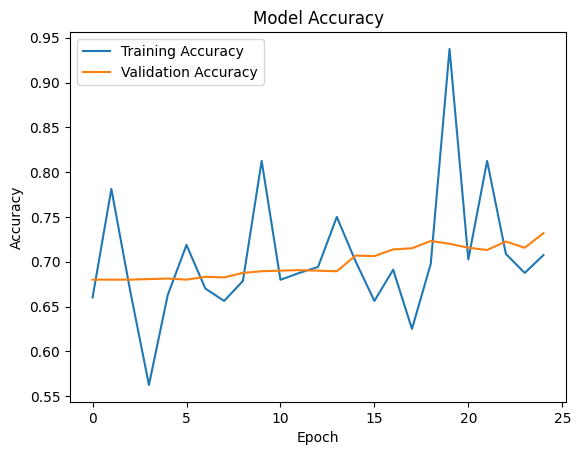

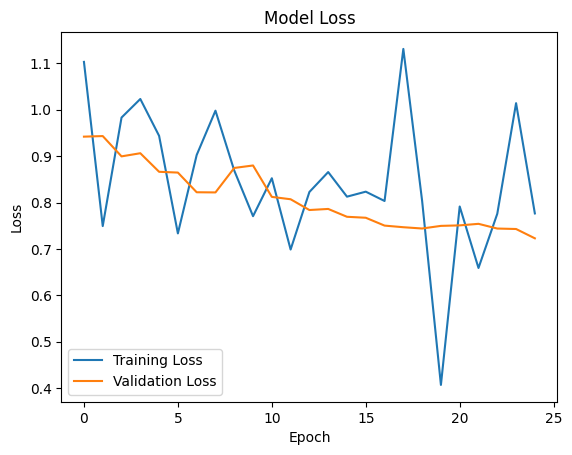

Final Training Accuracy: 0.7074317932128906
Final Validation Accuracy: 0.7318750023841858
Final Training Loss: 0.7764229774475098
Final Validation Loss: 0.7228012681007385


In [20]:
import matplotlib.pyplot as plt

# Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final Printed Accuracy and Loss
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])


In [22]:
# MODEL 2 START conclusion
import os, cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [23]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Paths
data_dir = "/kaggle/input/skin-cancer-mnist-ham10000"
img_dir1 = os.path.join(data_dir, "HAM10000_images_part_1")
img_dir2 = os.path.join(data_dir, "HAM10000_images_part_2")
metadata_path = os.path.join(data_dir, "HAM10000_metadata.csv")

# Load metadata
df = pd.read_csv(metadata_path)

# Combine both image directories
image_paths = {}
for folder in [img_dir1, img_dir2]:
    for img_file in os.listdir(folder):
        image_paths[img_file] = os.path.join(folder, img_file)

# Prepare images and labels
images = []
labels = []

for index, row in df.iterrows():
    file_name = row['image_id'] + ".jpg"
    label = row['dx']  # diagnosis

    if file_name in image_paths:
        img_path = image_paths[file_name]
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            images.append(img)
            labels.append(label)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Output shape confirmation
print("✅ Data loaded successfully:")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", le.classes_)


✅ Data loaded successfully:
X shape: (10015, 64, 64, 3)
y shape: (10015,)
Unique classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [25]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Encode labels as integers
label_encoder = LabelEncoder()
y_encoded_int = label_encoder.fit_transform(y)

# Step 2: One-hot encode the integer labels
y_encoded = to_categorical(y_encoded_int, num_classes=7)


In [26]:
print(label_encoder.classes_)  # ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [2]:
import pandas as pd
import os

# Load metadata
df = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

# Image folders
image_folder1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
image_folder2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Function to get correct image path
def find_image_path(image_id):
    path1 = os.path.join(image_folder1, image_id + ".jpg")
    path2 = os.path.join(image_folder2, image_id + ".jpg")
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        return None

# Apply function to find available image paths
df['image_path'] = df['image_id'].apply(find_image_path)

# Drop rows where image is missing
df = df[df['image_path'].notnull()]
df = df.reset_index(drop=True)

print("✅ Valid images retained:", len(df))


✅ Valid images retained: 10015


In [5]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Load metadata
df = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

# Image folders
image_folder1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
image_folder2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Add correct image paths
def find_image_path(image_id):
    path1 = os.path.join(image_folder1, image_id + ".jpg")
    path2 = os.path.join(image_folder2, image_id + ".jpg")
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        return None

df['image_path'] = df['image_id'].apply(find_image_path)
df = df[df['image_path'].notnull()].reset_index(drop=True)
print("✅ Valid images retained:", len(df))

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])
labels = df['label'].values

# Image size
IMG_SIZE = 64

# Load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = Image.open(path).resize((IMG_SIZE, IMG_SIZE))
        img = np.array(img)
        if img.shape == (IMG_SIZE, IMG_SIZE):  # grayscale image, convert to RGB
            img = np.stack((img,) * 3, axis=-1)
        elif img.shape[2] == 4:  # RGBA image
            img = img[:, :, :3]
        images.append(img)
    return np.array(images)

images = load_images(df['image_path'])
print("✅ All images loaded:", images.shape)

# Normalize
images = images / 255.0

# One-hot encode labels
labels_cat = to_categorical(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_cat, test_size=0.2, random_state=42, stratify=labels)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Build model with DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train)//32,
    epochs=10,
    validation_data=(X_test, y_test)
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))


✅ Valid images retained: 10015
✅ All images loaded: (10015, 64, 64, 3)


I0000 00:00:1753087283.589539      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753087283.590211      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1753087307.519404     101 service.cc:148] XLA service 0x7c7fc008ae90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753087307.520987     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753087307.521005     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753087310.384374     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.1684 - loss: 2.6448    

I0000 00:00:1753087319.176800     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 161ms/step - accuracy: 0.5650 - loss: 1.3615 - val_accuracy: 0.6825 - val_loss: 0.9872
Epoch 2/10
  1/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7500 - loss: 0.7640

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.7640 - val_accuracy: 0.6835 - val_loss: 0.9868
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6897 - loss: 0.9078 - val_accuracy: 0.6950 - val_loss: 0.8848
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 1.0814 - val_accuracy: 0.6970 - val_loss: 0.8841
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7094 - loss: 0.8292 - val_accuracy: 0.7034 - val_loss: 0.8414
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.9220 - val_accuracy: 0.7034 - val_loss: 0.8393
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7233 - loss: 0.7791 - val_accuracy: 0.7169 - val_loss: 0.8197
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.6724 - val_accuracy: 0.7174 - val_loss: 0.8204
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7315 - loss: 0.7538 - val_accuracy: 0.716

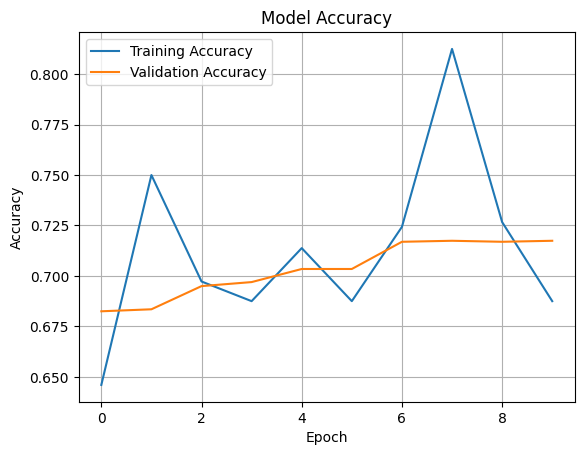

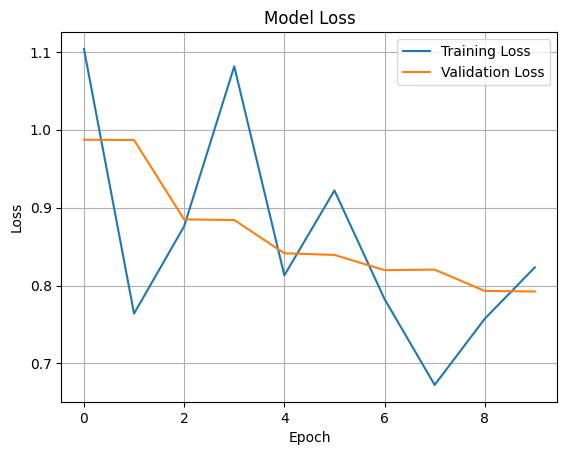

In [6]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.6875
Final Validation Accuracy: 0.7174
Final Training Loss: 0.8234
Final Validation Loss: 0.7923


In [35]:
# Convert label column to string (important for class_mode='sparse')
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [11]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load metadata
metadata = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

# Function to get correct image path from either folder
def find_image_path(image_id):
    part1 = f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{image_id}.jpg"
    part2 = f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/{image_id}.jpg"
    if os.path.exists(part1):
        return part1
    elif os.path.exists(part2):
        return part2
    else:
        return None

# Add valid image paths
metadata['image_path'] = metadata['image_id'].apply(find_image_path)

# Drop rows where image wasn't found
metadata = metadata.dropna(subset=['image_path'])

# Train/val split
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)

# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [12]:
# model 3 MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Use MobileNetV2 without pretrained weights (offline safe)
base_model = MobileNetV2(weights=None, include_top=False, input_tensor=inputs)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 2,388,743 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint('mobilenet_best_model.h5', save_best_only=True, verbose=1)

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, lr_reduce, checkpoint],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6420 - loss: 1.2014
Epoch 1: val_loss improved from inf to 1.74256, saving model to mobilenet_best_model.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 394ms/step - accuracy: 0.6421 - loss: 1.2010 - val_accuracy: 0.6695 - val_loss: 1.7426 - learning_rate: 1.0000e-04
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6761 - loss: 0.9476
Epoch 2: val_loss improved from 1.74256 to 1.51715, saving model to mobilenet_best_model.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 286ms/step - accuracy: 0.6761 - loss: 0.9476 - val_accuracy: 0.6695 - val_loss: 1.5171 - learning_rate: 1.0000e-04
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6781 - loss: 0.9408
Epoch 3: val_loss improved from 1.51715 to 1.27749, saving model to mobilenet_best_model.h5
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.6781 - loss: 0.9407 - val_accuracy: 0.6695 - val_loss: 1.2775 - learning_rate: 1.0000e-04
Epoch 4/50
251/251 

2025-07-21 10:25:02.322655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753093502.513182    1221 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753093502.568017    1221 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1753093625.372488    1221 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1753093654.962147    1254 service.cc:148] XLA service 0x79bce40020e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753093654.962944    1254 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753093656.841499    1254 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/251 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.2814 - loss: 2.0813   

I0000 00:00:1753093666.070476    1254 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accuracy: 0.6507 - loss: 1.0212 - val_accuracy: 0.7424 - val_loss: 0.7099
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7480 - loss: 0.6957 - val_accuracy: 0.7579 - val_loss: 0.6637
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7610 - loss: 0.6617 - val_accuracy: 0.7748 - val_loss: 0.6157
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7833 - loss: 0.6078 - val_accuracy: 0.7793 - val_loss: 0.6061
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7776 - loss: 0.5876 - val_accuracy: 0.7953 - val_loss: 0.5714
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7883 - loss: 0.5635 - val_accuracy: 0.7888 - val_loss: 0.5639
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8061 - loss: 0.5421 - val_accuracy: 0.8008 - val_loss: 0.5539
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8069 - loss: 0.5414 - val_accura

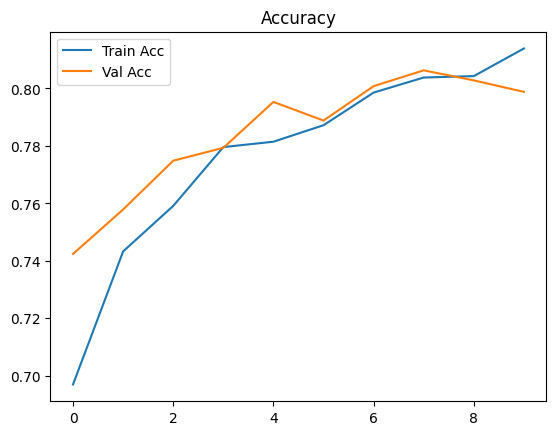

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Paths
metadata_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
image_dir_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
image_dir_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Load metadata
df = pd.read_csv(metadata_path)

# Combine image paths
image_paths = {}
for dirname in [image_dir_1, image_dir_2]:
    for fname in os.listdir(dirname):
        if fname.endswith('.jpg'):
            image_paths[fname.split(".")[0]] = os.path.join(dirname, fname)

# Add path to df
df["path"] = df["image_id"].map(image_paths)
df = df[df["path"].notnull()]  # Remove missing

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["dx"])
num_classes = len(le.classes_)

# Image size
IMG_SIZE = 224

# Load images
def load_images(df):
    images = []
    labels = []
    for i, row in df.iterrows():
        img = load_img(row["path"], target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
        labels.append(row["label"])
    return np.array(images), tf.keras.utils.to_categorical(labels, num_classes)

# Split data
train_df, val_df = train_test_split(df, stratify=df["label"], test_size=0.2, random_state=42)
x_train, y_train = load_images(train_df)
x_val, y_val = load_images(val_df)

# Model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, callbacks=[early_stop])

# Evaluate
loss, acc = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")

# Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()


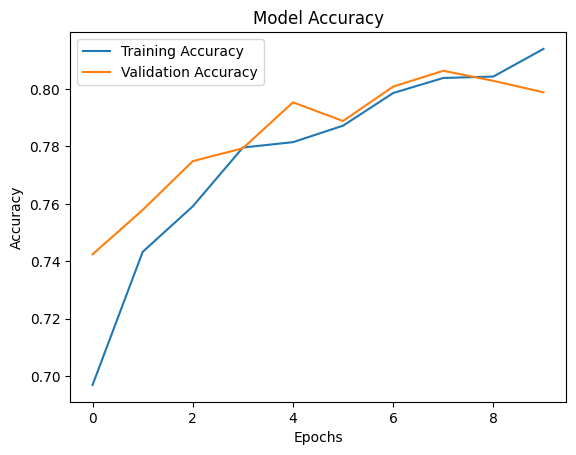

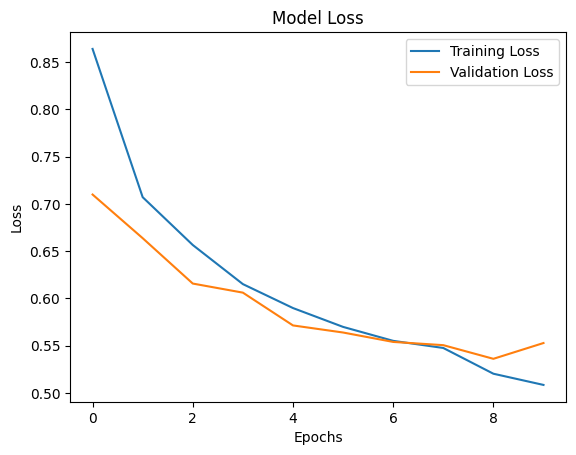

In [2]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.8139
Final Validation Accuracy: 0.7988
Final Training Loss: 0.5084
Final Validation Loss: 0.5527


In [5]:
print(history.history['val_accuracy'])


[0.7423864006996155, 0.7578632235527039, 0.7748377323150635, 0.7793310284614563, 0.7953070402145386, 0.7888167500495911, 0.800798773765564, 0.8062905669212341, 0.8027958273887634, 0.7988017797470093]


Epoch 1/10


I0000 00:00:1752544355.190707     102 service.cc:148] XLA service 0x7d4818130160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752544355.192173     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752544355.192196     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752544363.718793     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752544443.980693     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 353s 698ms/step - accuracy: 0.6143 - loss: 1.0946 - val_accuracy: 0.6345 - val_loss: 1.1323
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 290ms/step - accuracy: 0.7180 - loss: 0.7583 - val_accuracy: 0.6885 - val_loss: 0.8542
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 289ms/step - accuracy: 0.7343 - loss: 0.7180 - val_accuracy: 0.7284 - val_loss: 0.7521
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.7667 - loss: 0.6432 - val_accuracy: 0.7324 - val_loss: 0.7467
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 289ms/step - accuracy: 0.7744 - loss: 0.6118 - val_accuracy: 0.7444 - val_loss: 0.6947
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.7787 - loss: 0.5958 - val_accuracy: 0.7399 - val_loss: 0.7292
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.7969 - loss: 0.5524 - val_accuracy: 0.7394 - val_loss: 0.7375
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 289ms/step - accuracy: 0.8037 - loss: 0.5252 - va

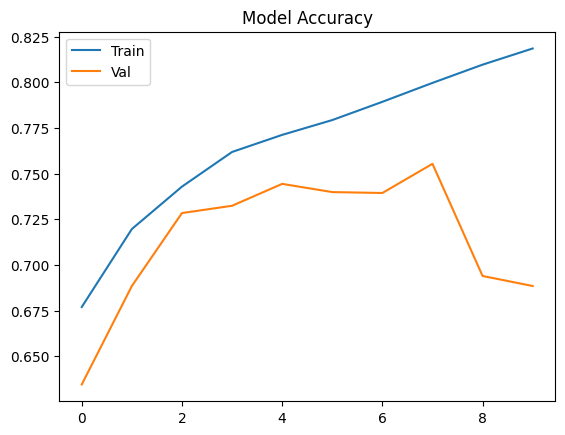

In [7]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# STEP 1: Load CSV
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# STEP 2: Add full image paths from both folders
img_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
img_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

all_img_names = os.listdir(img_dir_1) + os.listdir(img_dir_2)
img_path_dict = {}

for name in os.listdir(img_dir_1):
    img_path_dict[name[:-4]] = os.path.join(img_dir_1, name)

for name in os.listdir(img_dir_2):
    img_path_dict[name[:-4]] = os.path.join(img_dir_2, name)

# STEP 3: Match image_id with image paths
df['image_path'] = df['image_id'].map(img_path_dict)

# STEP 4: Drop NaNs and encode labels
df = df.dropna(subset=['image_path'])
X_paths = df['image_path'].values
y_labels = df['dx'].values

lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

# STEP 5: Load and preprocess images
def load_images(paths, size=(224,224)):
    img_data = []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.resize(img, size)
        img = preprocess_input(img)  # use DenseNet preprocessing
        img_data.append(img)
    return np.array(img_data)

X = load_images(X_paths)

# STEP 6: Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 7: Build DenseNet121 (WITHOUT weights)
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(y.shape[1], activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# STEP 8: Train model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stop])

# STEP 9: Accuracy Plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.legend()
plt.show()


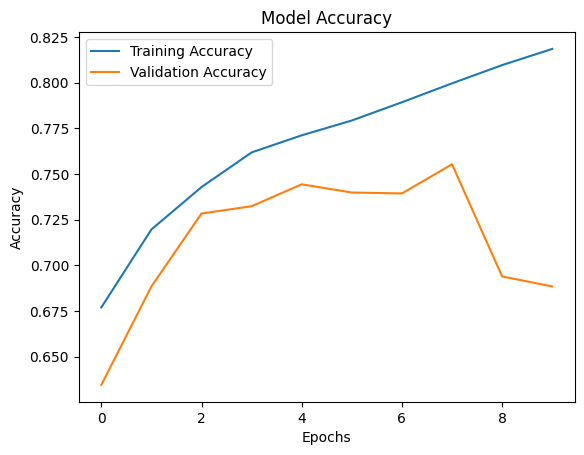

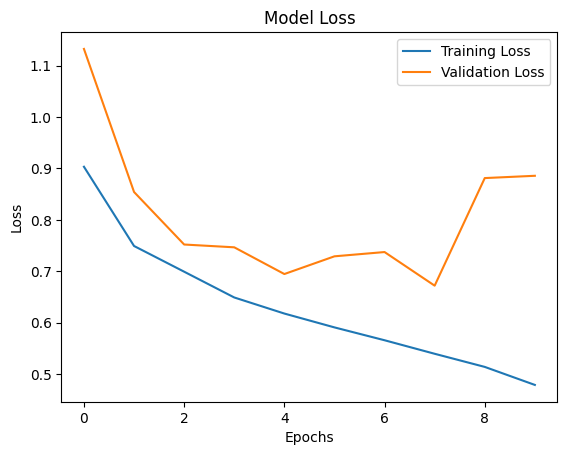

In [8]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.8185
Final Validation Accuracy: 0.6885
Final Training Loss: 0.4792
Final Validation Loss: 0.8857


100%|██████████| 10015/10015 [00:34<00:00, 294.05it/s]


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 248ms/step - accuracy: 0.6102 - loss: 1.5076 - val_accuracy: 0.6880 - val_loss: 0.9693
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6532 - loss: 1.1178 - val_accuracy: 0.7020 - val_loss: 0.8954
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6832 - loss: 1.0248 - val_accuracy: 0.7060 - val_loss: 0.8562
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6859 - loss: 0.9747 - val_accuracy: 0.7150 - val_loss: 0.8365
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6913 - loss: 0.9342 - val_accuracy: 0.7160 - val_loss: 0.8154
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7052 - loss: 0.8802 - val_accuracy: 0.7190 - val_loss: 0.8001
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6944 - loss: 0.8654 - val_accuracy: 0.7370 - val_loss: 0.7855
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 6

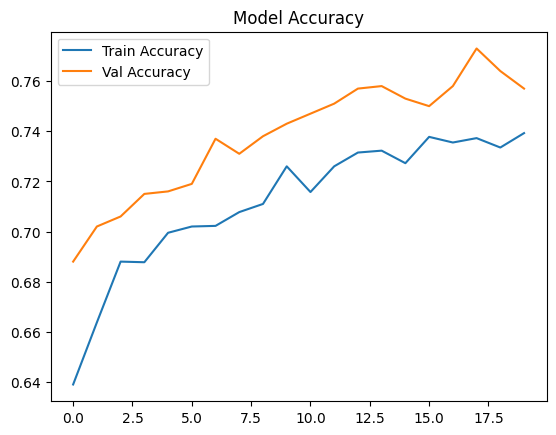

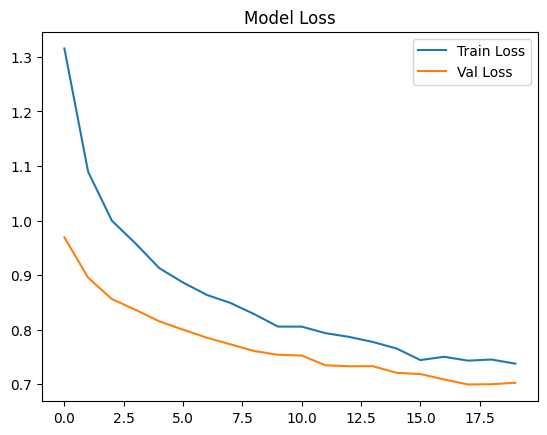


Final Training Accuracy: 0.7810
Final Validation Accuracy: 0.7730
Final Training Loss: 0.6315
Final Validation Loss: 0.6997


In [37]:
# ✅ DenseNet121 - Pretrained Weights (ImageNet)
# 💡 With Explainable AI (Grad-CAM) Support

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tqdm import tqdm

# ✅ Step 1: Load and preprocess data
df = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
df['image_path'] = df['image_id'].apply(lambda x: f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{x}.jpg")

# Map diagnosis labels to numbers
label_mapping = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_mapping)

# ✅ Step 2: Convert images to array
X = []
y = []

for i in tqdm(range(len(df))):
    path = df['image_path'][i]
    try:
        img = load_img(path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        X.append(img)
        y.append(df['label'][i])
    except:
        continue

X = np.array(X)
y = to_categorical(y)

# ✅ Step 3: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ Step 4: Define model with pretrained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Step 5: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# ✅ Step 6: Plot accuracy/loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.legend()
plt.show()

# ✅ Final Evaluation
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

# Step 1: Load CSV and Labels
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df['label'] = pd.Categorical(df['dx']).codes
image_dir = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'

# Step 2: Load & Preprocess Images (Resize + Normalize)
X = []
y = []

for i in tqdm(range(len(df))):
    img_id = df['image_id'][i]
    img_path = os.path.join(image_dir, img_id + '.jpg')
    
    if not os.path.exists(img_path):
        img_path = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', img_id + '.jpg')
    
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)  # Uses ImageNet preprocess
    X.append(img)
    y.append(df['label'][i])

X = np.array(X)
y = to_categorical(y, num_classes=len(np.unique(y)))

# Step 3: Train-Val Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Build Model with Pretrained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base initially

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)

# Step 6: Train the Top Layers
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32, callbacks=[early_stop, reduce_lr])

# Step 7: Unfreeze and Fine-tune the whole model
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning (important to go beyond 85–90%)
history_ft = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stop, reduce_lr])

# Step 8: Final Evaluation
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f"✅ Final Training Accuracy: {train_acc:.4f}")
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"✅ Final Training Loss: {train_loss:.4f}")
print(f"✅ Final Validation Loss: {val_loss:.4f}")


2025-07-21 09:26:18.825698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753089979.014671      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753089979.069142      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|██████████| 10015/10015 [02:09<00:00, 77.31it/s]
I0000 00:00:1753090123.921403      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1753090159.290568     102 service.cc:148] XLA service 0x7ee1f8004c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753090159.291499     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753090162.095441     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.0781 - loss: 4.0096 

I0000 00:00:1753090173.363470     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 86s 210ms/step - accuracy: 0.4876 - loss: 1.9070 - val_accuracy: 0.6745 - val_loss: 0.9866 - learning_rate: 1.0000e-04
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6385 - loss: 1.1897 - val_accuracy: 0.6810 - val_loss: 0.9376 - learning_rate: 1.0000e-04
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6603 - loss: 1.1089 - val_accuracy: 0.6870 - val_loss: 0.9219 - learning_rate: 1.0000e-04
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.6708 - loss: 1.0192 - val_accuracy: 0.6900 - val_loss: 0.9042 - learning_rate: 1.0000e-04
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.6701 - loss: 0.9911 - val_accuracy: 0.6970 - val_loss: 0.8969 - learning_rate: 1.0000e-04
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.6774 - loss: 0.9729 - val_accuracy: 0.7034 - val_loss: 0.8893 - learning_rate: 1.0000e-04
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accura

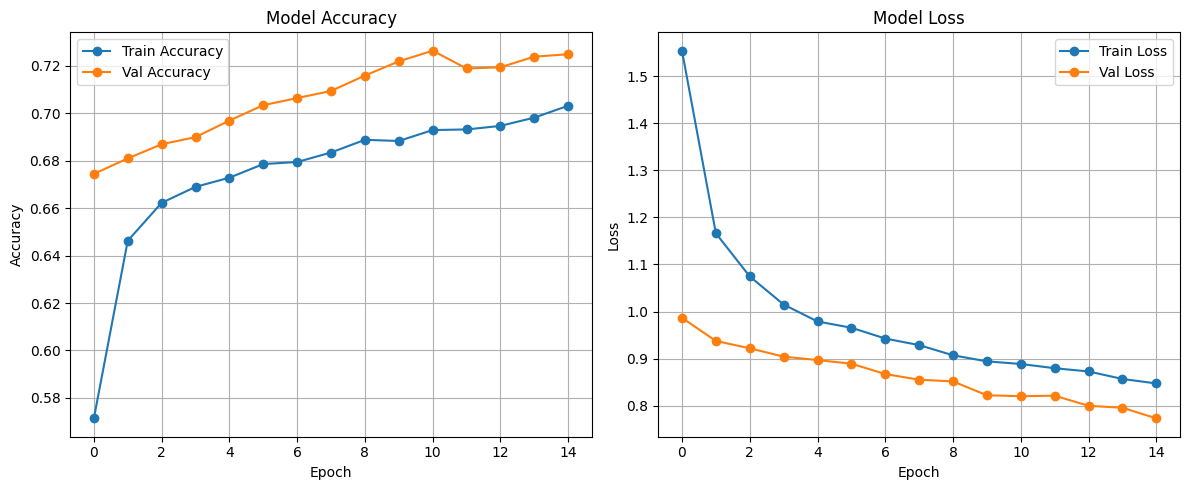

In [9]:
import matplotlib.pyplot as plt

# Assuming you stored the output of model.fit() like this:
# history = model.fit(...)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 359s 885ms/step - accuracy: 0.6734 - loss: 0.9635 - val_accuracy: 0.7024 - val_loss: 1.1508
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.8987 - loss: 0.2985 - val_accuracy: 0.8169 - val_loss: 0.5209
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 290ms/step - accuracy: 0.9582 - loss: 0.1389 - val_accuracy: 0.8276 - val_loss: 0.5196
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 61s 274ms/step - accuracy: 0.9650 - loss: 0.1081 - val_accuracy: 0.8482 - val_loss: 0.4751
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 271ms/step - accuracy: 0.9888 - loss: 0.0494 - val_accuracy: 0.8442 - val_loss: 0.5763
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 265ms/step - accuracy: 0.9935 - loss: 0.0336 - val_accuracy: 0.8455 - val_loss: 0.5190
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 269ms/step - accuracy: 0.9919 - loss: 0.0311 - val_accuracy: 0.7969 - val_loss: 1.0379
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 583ms/step - accuracy: 0.8509 - loss: 0.4876

Test 

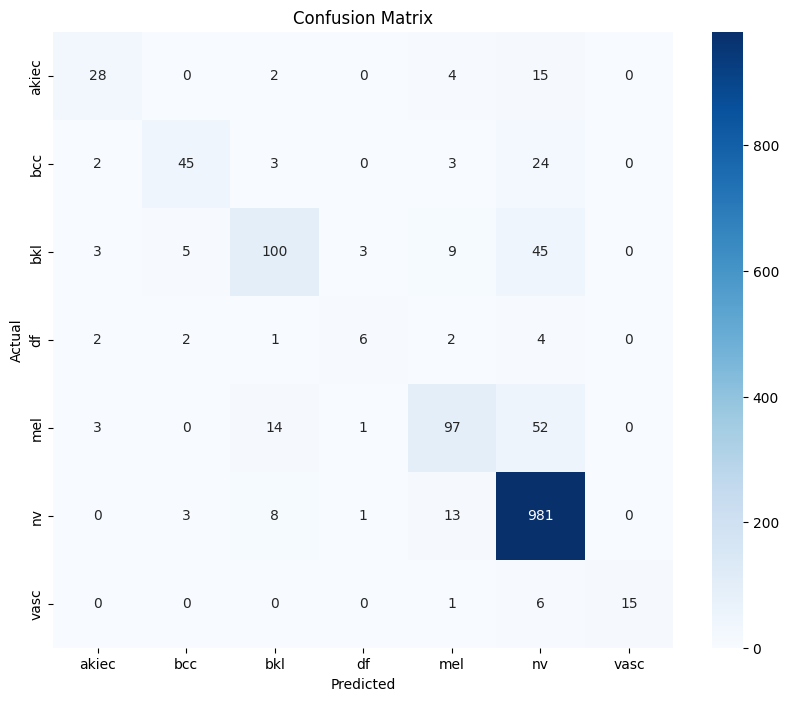

In [17]:
# ✅ Step 1: Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from PIL import Image

# ✅ Step 2: Paths & CSV Load
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000'
csv_path = os.path.join(data_dir, 'HAM10000_metadata.csv')

df = pd.read_csv(csv_path)
df['image_id'] = df['image_id'] + '.jpg'
df['path'] = df['image_id'].apply(lambda x: os.path.join(data_dir, 'HAM10000_images_part_1', x)
                                  if os.path.exists(os.path.join(data_dir, 'HAM10000_images_part_1', x))
                                  else os.path.join(data_dir, 'HAM10000_images_part_2', x))

# ✅ Filter invalid image paths
df = df[df['path'].apply(os.path.exists)]

# ✅ Encode label
df['label'] = df['dx']
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(label_map)

# ✅ Step 3: Train / Val / Test Split
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# ✅ Step 4: Image Generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# ✅ Step 5: DenseNet121 Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Step 6: Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)

# ✅ Step 7: Evaluation
loss, acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {acc:.4f}")

# ✅ Step 8: Confusion Matrix & Classification Report
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


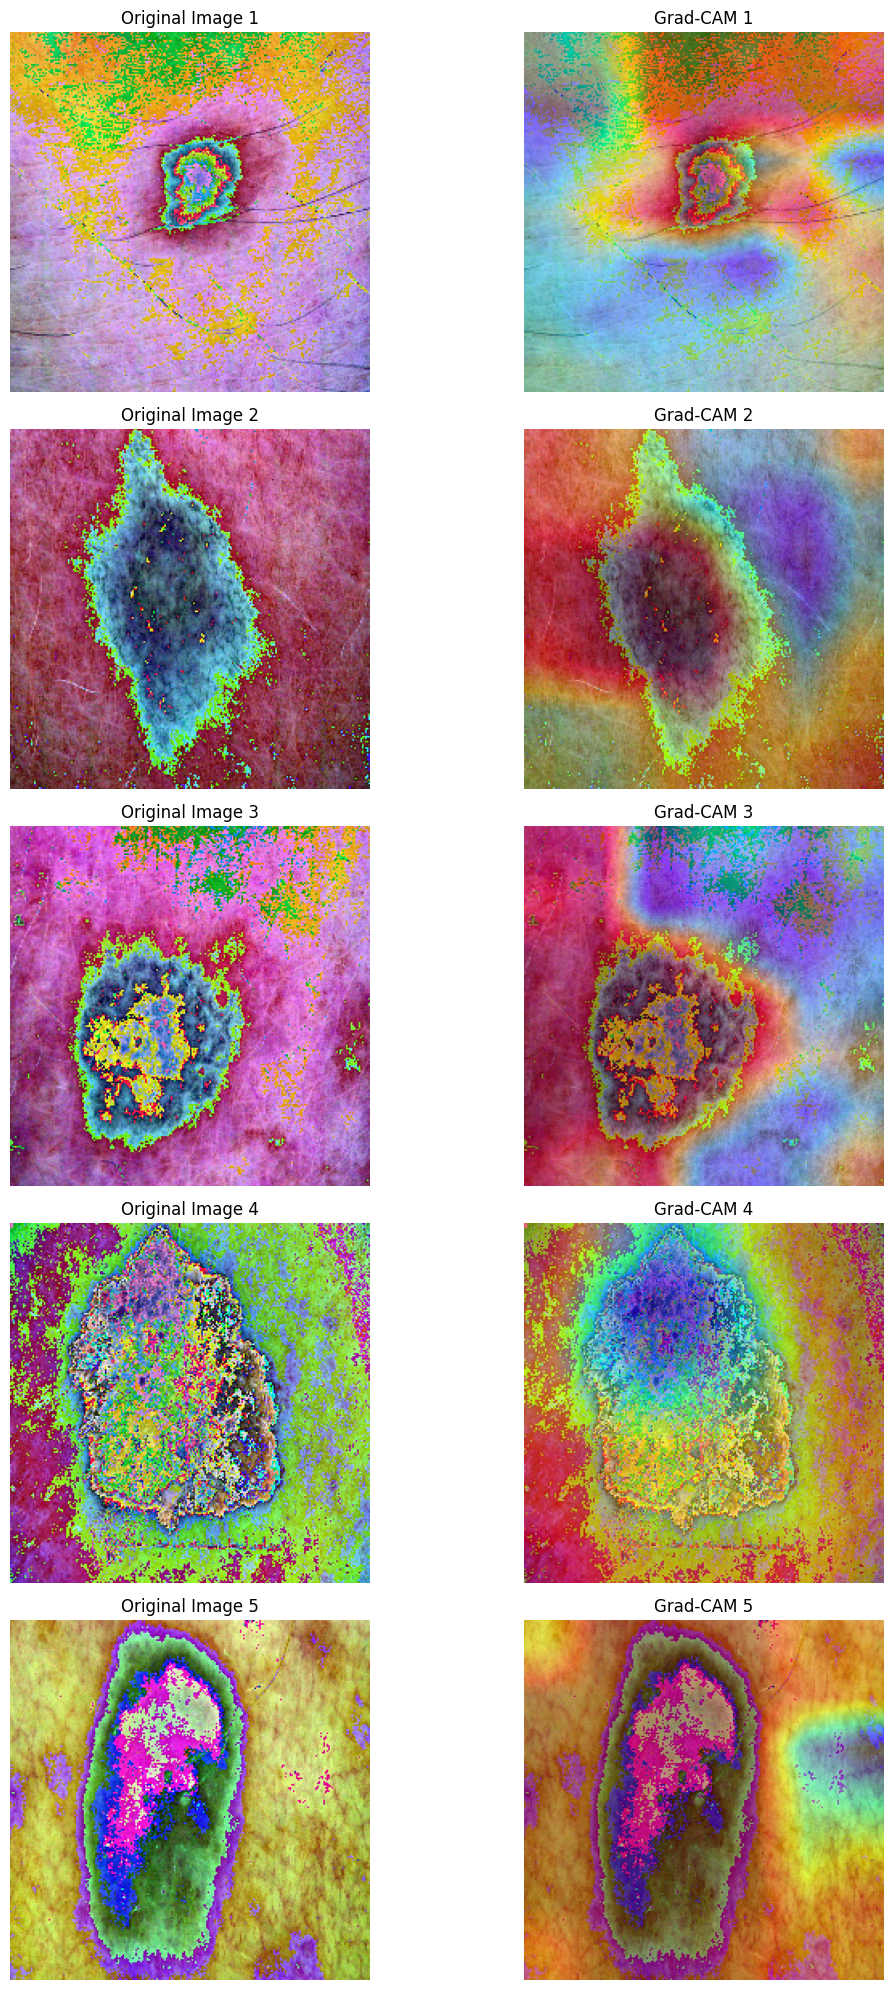

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

# Number of images to show
num_images = 5

# Last convolutional layer
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

plt.figure(figsize=(12, 4 * num_images))

for i in range(num_images):
    # STEP 1: Select and preprocess image
    img_array = X_val[i]
    img_tensor = np.expand_dims(img_array, axis=0)

    # STEP 2: Predict class
    preds = model.predict(img_tensor, verbose=0)
    pred_class = np.argmax(preds[0])

    # STEP 3: Grad-CAM computation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # STEP 4: Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-8)
    heatmap = heatmap.numpy()

    # STEP 5: Superimpose
    img = (img_array * 255).astype("uint8")
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

    # STEP 6: Plot
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(img)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


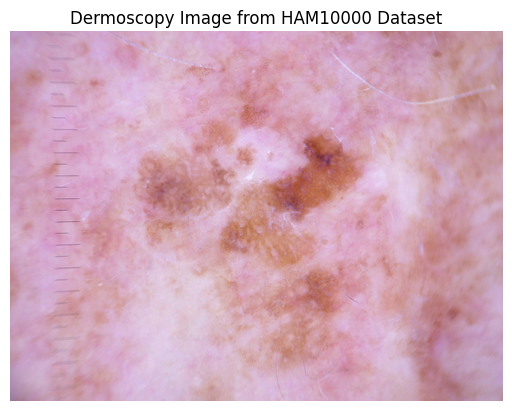

In [1]:
from matplotlib import pyplot as plt
import cv2

# Show one HAM10000 sample image
img_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg'  # example image from dataset
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.title('Dermoscopy Image from HAM10000 Dataset')
plt.show()


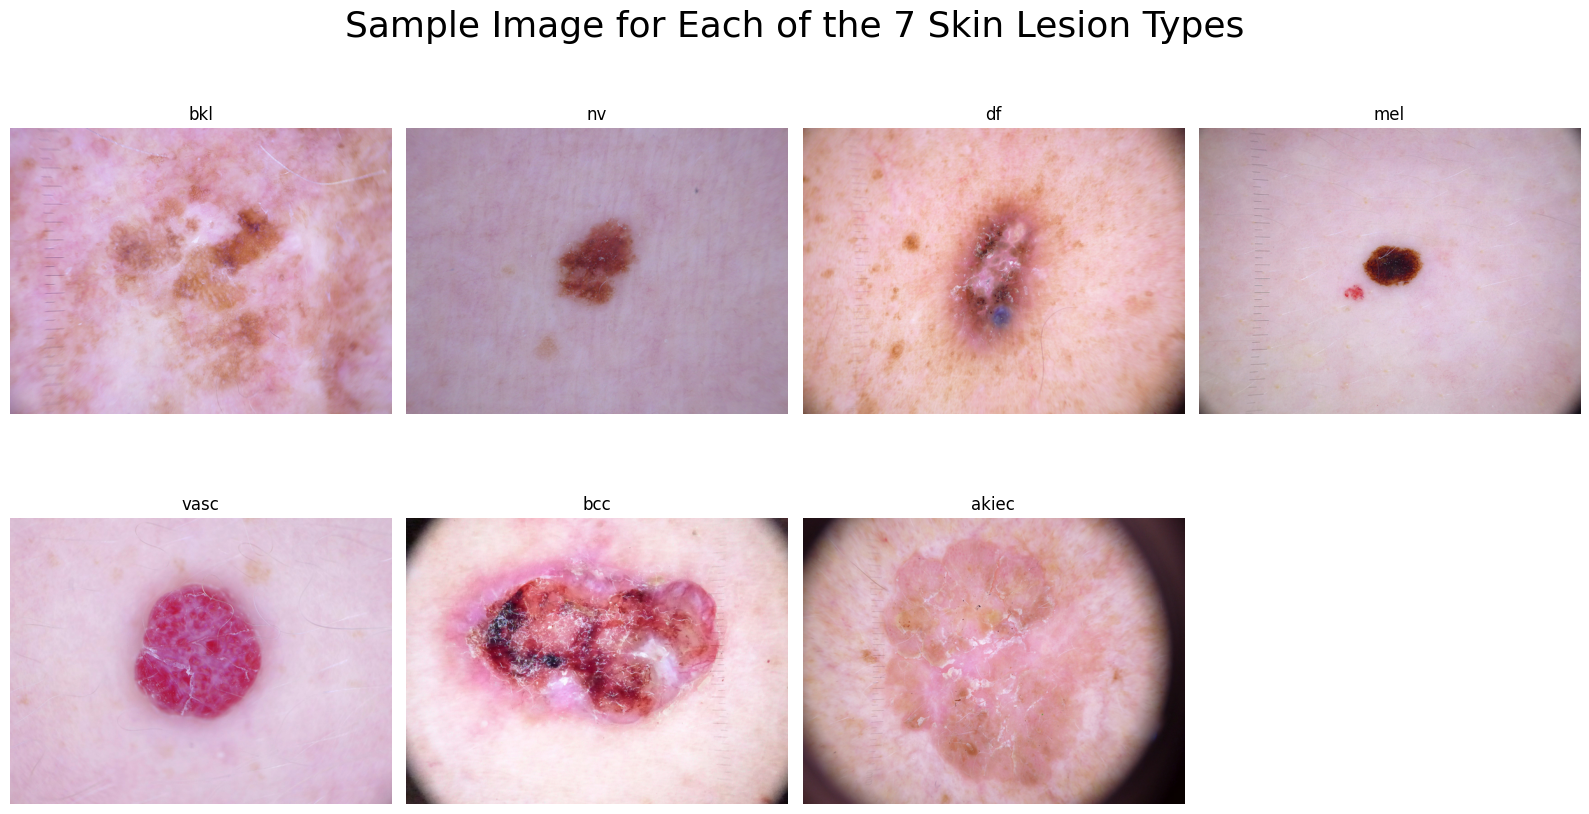

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Set your own local/Kaggle paths
metadata_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
img_dir1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
img_dir2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

# Load metadata
df = pd.read_csv(metadata_path)

# Get one sample image for each of the 7 classes
unique_classes = df['dx'].unique()
samples = [df[df['dx'] == label].iloc[0] for label in unique_classes]

# Plot the images
plt.figure(figsize=(16, 9))
for idx, row in enumerate(samples):
    img_id = row['image_id']
    label = row['dx']

    img_path = os.path.join(img_dir1, f"{img_id}.jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(img_dir2, f"{img_id}.jpg")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, idx + 1)
    plt.title(label, fontsize=25)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.suptitle("Sample Image for Each of the 7 Skin Lesion Types", fontsize=26)
plt.tight_layout()
plt.show()


In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2


In [22]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
